**Prediction using Adversarial Autoencoders For Fluid Problem** 

This notebook contains the workflow, development code and some results of the PredAAE for 2D turbulent fluid modelling completed as an independent research component of the M.Sc. degree in [Applied Computational Science and Engineering](https://www.imperial.ac.uk/earth-science/prosp-students/pg-courses/applied-computational-msc/) at Royal School of Mines at Imperial College London (ICL).

The project was part of the Applied Modelling and Computational Group @ ICL and was supervised by :
- Prof Christopher Pain
- Dr. Claire E. Heaney
- Vinicius Santos Silva 

This notebook is divided in sections that included data preprocessing tasks, core code body and results visualization. Part of this project is the data assimilation of sensor data. For more information about this and the rest of the work, here is a link to the report completed alongside this code devlopment. More details can also be found in the [github repository](https://github.com/acse-moj20/msc-irp)



Contact: Mustapha Jolaade, moj20@ic.ac.uk

September 02, 2021
[link text](https:// [link text](https://))




*Required environment and packages*

In [1]:
%matplotlib inline
import sys
import os
import sklearn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Plot formatting 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Processing and memory details

In [4]:
# ******** GPU Specifications *************
# *****************************************

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU info not found.')
else:
  print(gpu_info)
print('Num of available GPUs: ', len(tf.config.list_physical_devices('GPU')))

# ******** Allocated memmory *************
# ****************************************
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print()
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are using a high-RAM runtime!')

Fri Sep  3 15:02:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Utility Functions

Functions used for auxiliary tasks like error calculation, result visualization, data manipulation, etc.

In [5]:

def calculate_error(data, prediction):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  assert(len(data)==len(prediction))
  abs_error = abs(data - prediction)
  perc_error = abs_error*100/abs(data)
  max_abs_error = np.max(abs_error)
  mean_abs_error = np.mean(abs_error)
  return max_abs_error, mean_abs_error


def plot_vortex(data, times, cols, rows=1, skips=1, c_bar=True, cmap='RdBu'):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  fig, ax = plt.subplots(rows, cols, figsize=[5* cols, 20])
  for i, step in enumerate(times):
    im = ax.flatten()[i].imshow(data[step], cmap=cmap)
    if c_bar:
      cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.15, pad=0.05, panchor=(0.0, 0.0))
    ax.flatten()[i].set_title('t = {}'.format(step*skips), y=1.05, 
                          fontsize=16, fontweight="bold")
   
  plt.show()



def plot_linevortex(data_dict, times, cols, rows=1, skips=1):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  # use a gray background
  fig, ax = plt.subplots(rows, cols, figsize=[5* cols, 9], sharey='all')
  
  for i, step in enumerate(times):
    #im = ax.flatten()[i].imshow(data[step], cmap=cmap)
    for label in data_dict:
      plot_data = data_dict[label]
      plot_data_1d = plot_data[step].reshape(-1, 1)
      line_plt = ax.flatten()[i].plot(plot_data_1d, label=label)
      
      # Plot max and min locations
      ax.flatten()[i].plot(np.where(plot_data_1d == np.amax(plot_data_1d))[0], 
               np.amax(plot_data_1d), "bo", label='Pos. vortex')
      ax.flatten()[i].plot(np.where(plot_data_1d == np.amin(plot_data_1d))[0], 
               np.amin(plot_data_1d), "ro", label='Neg. vortex')

    if i == 0:
      ax.flatten()[i].legend(loc='best', prop={'size':10})
      ax.flatten()[i].set_ylabel('Magnitude of vortices')
    ax.flatten()[i].set_title('t = {}'.format(step*skips), y=1.05, 
                          fontsize=16, fontweight="bold")
    fig.text(0.5, -0.04, '1D Spatial domain', fontdict={
        'weight': 'normal',
        'size': 14,}, ha='center')
    
    
  plt.show()

def concat_timesteps(X_train, ntimes, step, window_start, window_end, verbose=0):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  X_train_concat = []
  for start, end in zip(window_start, window_end):
    for i in range(start, end+step): 
      X_train_concat.append(X_train[i:i+ntimes*step:step])
      if verbose:
        print('sample starts from {} :'.format(i))
        for j in range(i, i+ntimes*step, step):
          print('{}'.format(j) , end=', ')
        print('\n')
  return np.array(X_train_concat)

def invert_data(X_data, flag=None):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  if flag=='3':
    X_scale_inverted = scaler3.inverse_transform(X_data)
    X_pca_inverted = pca3.inverse_transform(X_scale_inverted)
  else:
    X_scale_inverted = scaler.inverse_transform(X_data)
    X_pca_inverted = pca.inverse_transform(X_scale_inverted)
  return X_pca_inverted



def transform_data(X_data):
  '''
  Computes the absolute and percentage error between two arrays.
  Arrays must be of equal length.

  Parameters
  ----------
      data : ndarr
          m-by-n array of true values.
      data_recovered : ndarr
          m-by-n array of predicted values.

  Returns
  -------
      max_abs_error (float)
          max absolute error between data and prediction.
      mean_abs_error (float)
          mean absolute error between data and prediction.
  '''
  X_pca = pca.fit_transform(X_data)
  X_pca_scaled = scaler.fit_transform(X_pca)
  return X_pca_scaled


#**POD Based Non-Intrusive Reduced Order Modelling**

##Data Details

*   Raw dataset represents the parameter values of u, v and p for 1200 separate examples of the high fidelity solution.
*   Each example is computed over 50 timesteps and a on a 256-by-256 grid.

*   Vorticity over the vector field is obatined by computing the curl of u (x-component velocity vector) and v (y-component velocity vector)


**Note:** Due to memory constraints, only implementation of a fraction of the dataset (100 trajectories - 7GB) is shown here. The workflow does not chnage for a much larger dataset.






In [ ]:
# Load x and y velocity components 
data_dir = 'drive/MyDrive/MSC_IRP/data/vortex_100.npy'
data_file = np.load(data_dir)

# Print data details
print('Size of dataset:         ', data_file.shape)
print('Number of data samples:  ', len(data_file))
print('Size of each sample:     ', data_file[0].shape)
print('Number of time steps:    ', len(data_file[0]))

Size of dataset:          (100, 50, 256, 256, 3)
Number of data samples:   100
Size of each sample:      (50, 256, 256, 3)
Number of time steps:     50


In [ ]:

# *** Computing vorticity from vector field ***
# *********************************************

def curl(u,v):
  """ 
  Function to calculate the curl of a 2-dimensional vector field.
  Parameters:
  -----------
    u : 2d array of size n*m
      vector component in the x direction.

    v : 2d array of size n*m
      vector component in the y direction
  Output:
  -------
    curl : 2d array of size n*m
      curl of vector field [i.e. (dv/dx)i - (du/dy)j]
  """
  curl = np.gradient(v)[0] - np.gradient(u)[1]
  return curl

def process(data, save=False):
  """ 
  Function to calculate the curl of a 2-dimensional vector field.
  Parameters:
  -----------
    u : 2d array of size n*m
      vector component in the x direction.

    v : 2d array of size n*m
      vector component in the y direction
  Output:
  -------
    curl : 2d array of size n*m
      curl of vector field [i.e. (dv/dx)i - (du/dy)j]
  """
  assert(len(data)>0)
  assert(len(data.shape) > 3)
  size = len(data)

  vorticity = np.zeros_like(data[:,:,:,:,0])
  # placehodler for vorticity 
  start = time.time()
  for i in range(len(data_file)):
    for j in range(len(data_file[0])):
      vorticity[i][j] = curl(data_file[i][j][:, :, 0], data_file[i][j][:, :, 1])
  if save:
    save_dir = 'drive/MyDrive/MSC_IRP/data/calc_vortex_' + str(len(data))+'.npy'
    np.save(save_dir, vorticity)
    print(' Processed data saved at: ' + save_dir)
  print('--------- Done in {:.5f}s. -------- '.format( time.time()-start))
  return vorticity

In [ ]:
trajs = process(data_file)

--------- Done in 10.43701s. -------- 


##Dataset visualization

In [ ]:
trajs.shape

(100, 50, 256, 256)

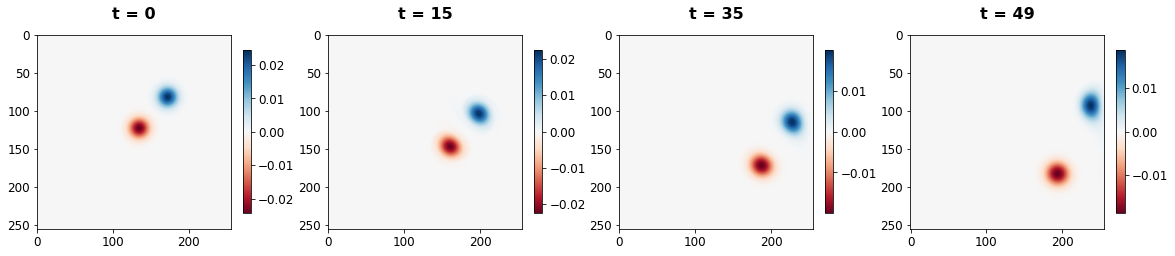

In [ ]:
# We want to visualize the trajectory at times: 0, 15, 35 and 49
idx = 0
times = [0, 15, 35, 49]
plot_vortex(trajs[idx], times, cols=4, rows=1)


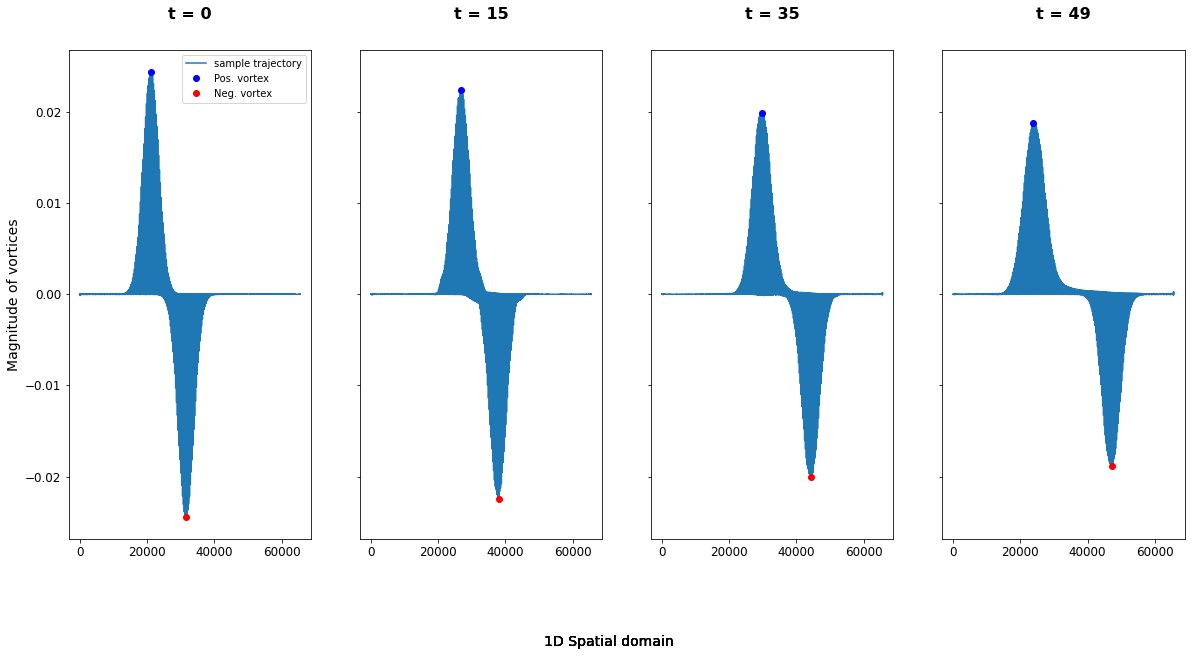

In [ ]:
# We want to visualize the trajectory projected on a linear domain to observe vortices magnitude
plot_linevortex({'sample trajectory': trajs[idx]}, times, cols=4, rows=1)

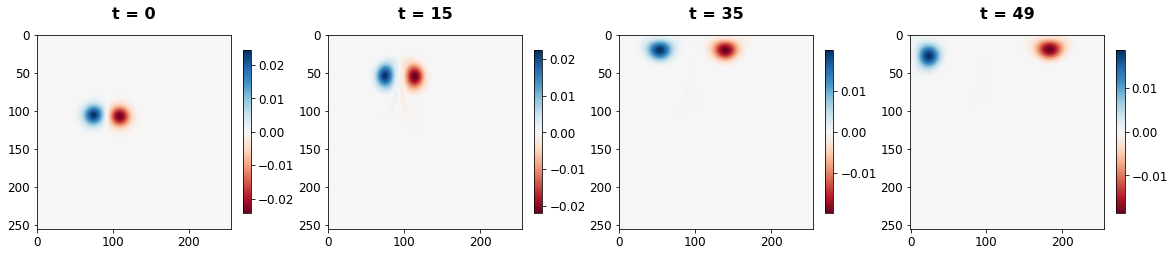

In [ ]:
plot_vortex(trajs[69], times, cols=4, rows=1)

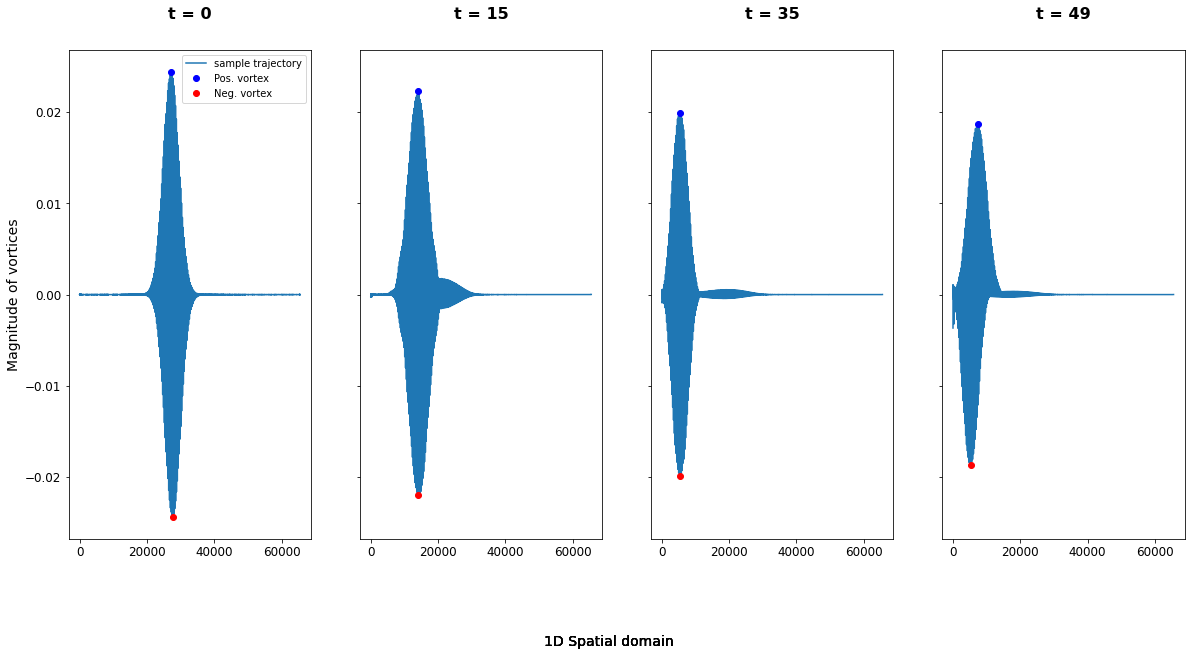

In [ ]:
plot_linevortex({'sample trajectory': trajs[69]}, times, cols=4, rows=1)

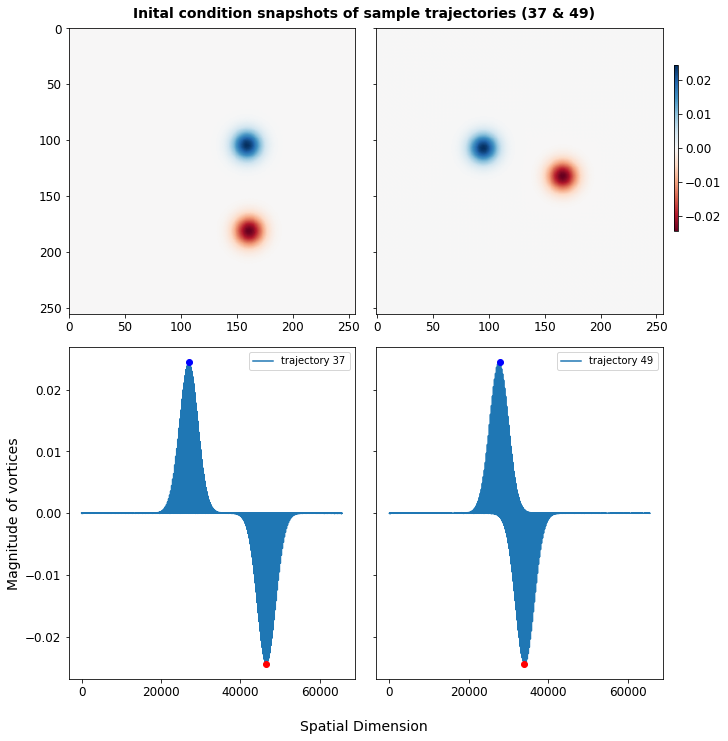

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


In [ ]:
# Reverse transform concatenated series to check correctness
fig, ax = plt.subplots(2, 2, figsize=[10,10], sharex='row', sharey='row', constrained_layout=True)
im = ax.flatten()[0].imshow(trajs[37][0], cmap='RdBu')
im = ax.flatten()[1].imshow(trajs[49][0], cmap='RdBu')

ax.flatten()[2].plot(trajs[37][0].reshape(-1, 1), label='trajectory 37')
ax.flatten()[2].legend()

# Plot max and min locations
ax.flatten()[2].plot(np.where(trajs[37][0].reshape(-1, 1) == np.amax(trajs[37][0].reshape(-1, 1)))[0], 
          np.amax(trajs[37][0].reshape(-1, 1)), "bo", label='Pos. vortex')
ax.flatten()[2].plot(np.where(trajs[37][0].reshape(-1, 1) == np.amin(trajs[37][0].reshape(-1, 1)))[0], 
          np.amin(trajs[37][0].reshape(-1, 1)), "ro", label='Neg. vortex')

ax.flatten()[3].plot(trajs[49][0].reshape(-1, 1), label='trajectory 49')
ax.flatten()[3].legend()
ax.flatten()[3].plot(np.where(trajs[49][0].reshape(-1, 1) == np.amax(trajs[49][0].reshape(-1, 1)))[0], 
          np.amax(trajs[49][0].reshape(-1, 1)), "bo", label='Pos. vortex')
ax.flatten()[3].plot(np.where(trajs[49][0].reshape(-1, 1) == np.amin(trajs[49][0].reshape(-1, 1)))[0], 
          np.amin(trajs[49][0].reshape(-1, 1)), "ro", label='Neg. vortex')

fig.text(0.5, -0.04, 'Spatial Dimension', fontdict={
        'weight': 'normal',
        'size': 14,
        }, ha='center')
fig.text(0.5, 0.95,  'Inital condition snapshots of sample trajectories (37 & 49)', fontdict={
        'weight': 'bold',
        'size': 14,
        }, ha='center')
ax[1, 0].set_ylabel('Magnitude of vortices')
fig.colorbar(im, ax=ax[0,:].flatten(), shrink=0.5, pad=0.00, panchor=(0.0, 0.0))
plt.show()

fig.tight_layout()

##Dimensionality reduction - POD/PCA

The training dataset consists of samples of a high-fidelity numerical simulation each with 50 evenly sampled snapshots (in time). Each simulation represents velocity (in x and y directions) and pressure for the turbulent flow model over a region of grid size 256x256. These values can be used to generate a vorticity field for the model. Thus, there is a total number of 256 * 256 = 65,536 variables per time step and a total of 50 * 100 = 5,000 samples. Dimensionality reduction of this high dimensional space is then performed using Principal Component Analysis (PCA) in order to work with a relatively low dimension space. The PCA model uses 292 expansion coefficients that gave > 99.9% variance in the reduction.

In [ ]:
trajs.shape

(100, 50, 256, 256)

###Build PCA Model

First we find the appropriate number of POD expansion coefficients given the requirement to retain 99.99% of information/relative cumulative energy, p. 
Below we show that 292 modes is appropriate to fulfill the criteria. 

The model reduction is then carried out using the number of modes. 

In [ ]:
nx = trajs.shape[-2]  # snapshot x dim
ny = trajs.shape[-1]  # snapshot y dim
trajs_1d = trajs.reshape((-1, nx*ny))
print(trajs_1d.shape)

# Initiate PCA
pca = PCA(trajs_1d.shape[0])
trajs_pca = pca.fit_transform(trajs_1d)

(5000, 65536)


In [ ]:
X_recovered_1d = pca.inverse_transform(X_train_pca)
np.allclose(X_recovered_1d, X_train1d)

True

In [ ]:
p = 0.999
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
n_components_eig = np.argmax(cumsum_eig >= p) + 1 # returns the indices of the maximum values along an axis.
n_components_eig

292

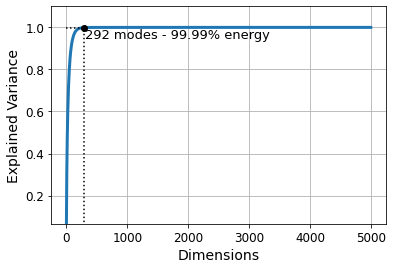

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([n_components_eig, n_components_eig], [0, p], "k:")
plt.plot([0, n_components_eig], [p, p], "k:")
plt.plot(n_components_eig, p, "ko")
plt.annotate("292 modes - 99.99% energy", xy=(n_components_eig, p), xytext=(n_components_eig+10, p-0.05), fontsize=13)
plt.grid(True)
plt.show()

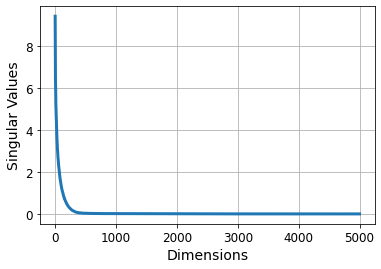

In [ ]:
sv = pca.singular_values_
plt.figure(figsize=(6,4))
plt.plot(sv, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Singular Values")
plt.grid(True)
plt.show()

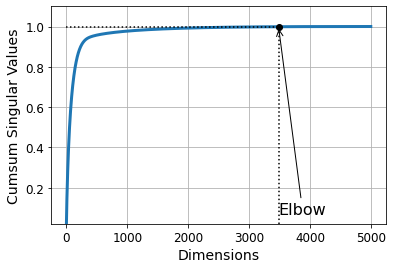

3484


In [ ]:
p = 0.999
cumsum_sv = np.cumsum(pca.singular_values_/sum(pca.singular_values_))
n_components_sv = np.argmax(cumsum_sv >= p) + 1

d = n_components_sv
plt.figure(figsize=(6,4))
plt.plot(cumsum_sv, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Singular Values")
plt.ylim([cumsum_sv[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_sv[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()
print(d)

**Re-compression using 292 components)**

In [ ]:
pca_rom = PCA(n_components=n_components_eig)
trajs_pca = pca_rom.fit_transform(trajs_1d)
trajs_reconstruct = pca_rom.inverse_transform(trajs_pca)
print(trajs_pca.shape)
np.allclose(trajs_reconstruct, trajs_train1d)

(5000, 292)


False

In [ ]:
# Comparing actual data and pca reduced data
actual_data = X_train1d.reshape((-1, timestep, nx, nx))[89]
recon_data = X_reconstruct.reshape((-1, timestep, nx, nx))[89]
plot_vortex(actual_data, times, len(times))

In [ ]:
plot_vortex(recon_data, times, len(times))

In [ ]:
# Calculate error 

max_abs_err, mean_abs_err = calculate_error(actual_data, recon_data)
print("Max. abs. error: {}". format(max_abs_err))
print("Mean abs. error: {}".format(mean_abs_err))

Max. abs. error: 0.0026068006677143927
Mean abs. error: 5.0103895884519914e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [ ]:
# Save compression
import joblib
pca_file_dir = "drive/MyDrive/MSC_IRP/PredGAN/pca_rom_292.pkl"
with open(pca_file_dir, 'wb') as save_file:  
  joblib.dump(pca_rom, save_file)
np.save('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_100.npy', X_train_pca)

#**Training Generative Adversarial Network**

Following reduction in dimension, we can now proceed to train a GAN/WGAN-GP for time series prediction using the POD axpansion coefficients. 

Prior to traing the GAN, we perform a time series concatenation of the 50 snapshots of a trajectory. This is necessary for timeseries prediction as the GAN needs to be learn what future state of each trajectory is. 
In contenating the snapshots, we select a suitable length of the resulting concantenation. This is also the max. length the GAN can generate/predict.
```
ntimes
```
To ensure coverage, we implement user-specified gap between consecutive time level in the concatenation so a good portion of the trajectry is learned. This variable is:
```
step
```
To concatenate, a helper function
```
concatenate_timesteps(reduced_trajs, ntimes, step, window_start, window_end)
```
is built that contenates within a window since there is limited snashots for each trajectory. The output trajectories are then used as training data. 
 

In [6]:
# ********* Data details ***********
# **********************************
mem_load = True
SAVE_DIR = 'drive/MyDrive/MSC_IRP/PredGAN/'

# spatial domain 
nx = 256 
ny = nx

# temporal domain
timestep = 50 

num_of_coeff = 292
ntimes = 7 # Consecutive times for the GAN
step = 5 # step between times



### Load Compressed Trajectories v1200

In [70]:
if (mem_load):
  pca = joblib.load('drive/MyDrive/MSC_IRP/data/pca_rom1200_292.pkl')
  X_1d_pca = np.load('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_1200.npy')
  scaler = joblib.load('drive/MyDrive/MSC_IRP/data/scaler_1200.pkl')
  
print('Number of snapshots: {}'.format(X_1d_pca.shape[0]))
X_1d_pca_scaled = scaler.fit_transform(X_1d_pca)
# np.allclose(X_1d_pca, scaler.inverse_transform((X_1d_pca_scaled)))

Number of snapshots: 60000


### Load Compressed Trajectories v300

In [13]:
if (mem_load):
  pca3 = joblib.load('drive/MyDrive/MSC_IRP/data/pca_rom300_292.pkl')
  X_1d_pca3= np.load('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_300.npy')
  scaler3 = joblib.load('drive/MyDrive/MSC_IRP/data/scaler_300.pkl')
  
print('Number of snapshots: {}'.format(X_1d_pca3.shape[0]))
X_1d_pca_scaled3 = scaler3.fit_transform(X_1d_pca3)


Number of snapshots: 15000


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Test dimension reduction and visualize data

(50, 256, 256)


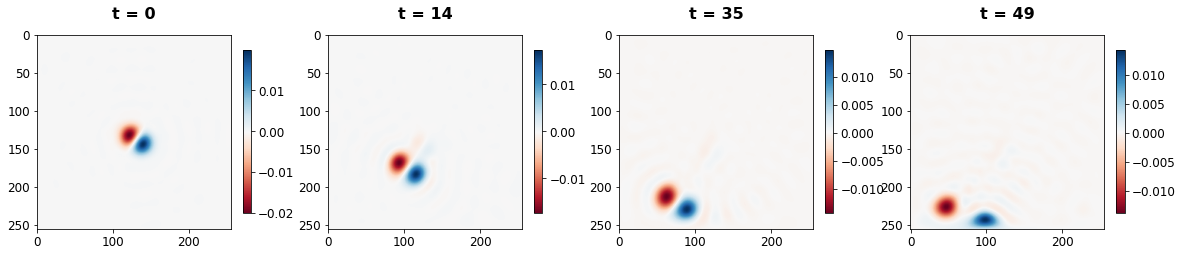

In [71]:
# Test diemnsionality reduction
# ******************************
times = [0, 14, 35, 49]
X_recovered = invert_data(X_1d_pca_scaled[10650:10700]).reshape(timestep, nx, ny)
print(X_recovered.shape)
plot_vortex(X_recovered, times, len(times))

#### Load model with choice of sensors

In [8]:
from tensorflow.keras.models import load_model
mode='orig'
num_sensors=0

discriminator = load_model(SAVE_DIR+'ganmodels/model_vE1000_125b_AAE2_disc_20000.h5')
encoder = load_model(SAVE_DIR + 'ganmodels/model_vE1000_125b_AAE2_enc_20000.h5')
decoder = load_model(SAVE_DIR + 'ganmodels/model_vE1000_125b_AAE2_dec_20000.h5')

latent_space = 1000

if mode=='sensor':
  num_sensors = 25
  
  discriminator = load_model(SAVE_DIR+'ganmodels/model_vE500_125b_AAEsen_disc_8000.h5')
  encoder = load_model(SAVE_DIR + 'ganmodels/model_vE500_125b_AAEsen_enc_8000.h5')
  decoder = load_model(SAVE_DIR + 'ganmodels/model_vE500_125b_AAEsen_dec_8000.h5')

  latent_space = 500

### Time series Concatenation

In [133]:
# Time series Concantenation
sample_size = int(X_train1d_pca_scaled.shape[0]/timestep) 
window_start = [(sample*timestep)for sample in range(sample_size)]
window_end = [(sample*timestep) - (ntimes*step) for sample in range(1, sample_size + 1)]
X_train_concat = concat_timesteps(X_train1d_pca_scaled, ntimes, step, window_start, window_end)

if mode == 'sensor':
  # Grid pointfor sensor data creation
  grid_points = [
                [0,50],[0,100],[0,150],[0,200],[0,250],
                  [50,50],[50,100],[50,150],[50,200],[50,250],
                  [100,50],[100,100],[100,150],[100,200],[100,250],
                  [150,50],[150,100],[150,150],[150,200],[150,250],
                [250,50],[250,100],[250,150],[250,200],[250,250],
                ]
  sensor_image = invert_data(X_train_concat[-1]).reshape(-1, nx, nx)
  sensor_data = np.zeros((ntimes, num_sensors))
  for i, [a, b] in enumerate(grid_points):
    sensor_data[:, i] = sensor_image[:, a, b]
  print(sensor_data.shape)

  # Data sensor concatenation
  X_train_concat_sensor = np.zeros((X_train_concat.shape[0], ntimes, num_of_coeff+num_sensors))
  for i in range(len(X_train_concat)):
    X_train_concat_sensor[i] = np.concatenate((X_train_concat[i], sensor_data), axis=1) 
  X_train_concat = X_train_concat_sensor.copy()

X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], (num_of_coeff + num_sensors)*ntimes)



print(' Number of concatenated time series for training: ', X_train_concat.shape[0])
print('---------------')
print('Test output:')
print(X_train_concat.shape)
print(X_train_concat_flatten.shape)

 Number of concatenated time series for training:  24000
---------------
Test output:
(24000, 7, 292)
(24000, 2044)


In [14]:
# Version 300. No train test split
X_train1d_pca_scaled3 = X_1d_pca_scaled3.reshape(-1, num_of_coeff)
sample_size = int(X_train1d_pca_scaled3.shape[0]/timestep) 
window_start = [(sample*timestep)for sample in range(sample_size)]
window_end = [(sample*timestep) - (ntimes*step) for sample in range(1, sample_size + 1)]


X_train_concat3 = concat_timesteps(X_train1d_pca_scaled3, ntimes, step, window_start, window_end)
X_train_concat_flatten3 = X_train_concat3.reshape(X_train_concat3.shape[0], num_of_coeff*ntimes)
print(' Number of concatenated time series for training: ', X_train_concat3.shape[0])
print('---------------')
print('Test output:')
print(X_train_concat3.shape)
print(X_train_concat_flatten3.shape)

 Number of concatenated time series for training:  6000
---------------
Test output:
(6000, 7, 292)
(6000, 2044)


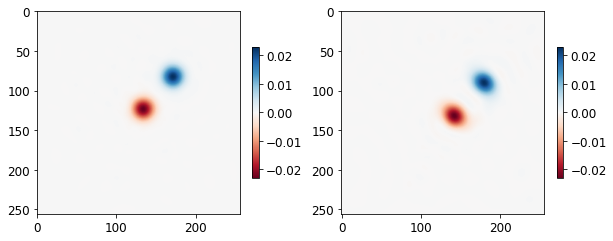

(7, 65536)


In [ ]:
# Reverse transform concatenated series to check correctness
fig, ax = plt.subplots(1, 2, figsize=[10,10])
X_ = invert_data(X_train_concat[0, :, :])
im = ax[0].imshow(X_[0,:].reshape(nx, nx), cmap='RdBu')
im = ax[1].imshow(X_[1, :].reshape(nx, nx), cmap='RdBu')
fig.colorbar(im, ax=ax.flatten()[0], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
fig.colorbar(im, ax=ax.flatten()[1], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
plt.show()
print(X_.shape)


Dataset Creation

In [14]:
# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, num_of_coeff+num_sensors, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat)).batch(BATCH_SIZE, drop_remainder=True)

### Adversarial Autoenocder

AAE Hyperparameters


In [135]:
g_lr = 1e-4
d_lr = 1e-4
num_examples_to_generate = 15

BATCH_SIZE = 125

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# Seed and intitialization
seed = tf.random.normal([num_examples_to_generate, latent_space])

#### Build model

In [ ]:
def build_encoder():

    #weight initialization
    # init = tf.initializers.RandomNormal(stddev=0.02)
  
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[ntimes, num_of_coeff, 1]))
    model.add(tf.keras.layers.Dense(1, use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.3))

    model.add(tf.keras.layers.Conv2D(256, (3, 7), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.3)) 

    model.add(tf.keras.layers.Conv2D(128, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.3))

    model.add(tf.keras.layers.Conv2D(64, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.3))

    model.add(tf.keras.layers.Conv2D(32, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(latent_dim))
   

    #model.compile(optimizer=generator_optimizer, loss=generator_loss)

    return model
encoder = build_encoder()
encoder.summary()

In [ ]:
def build_decoder():
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.InputLayer(input_shape=[latent_dim]))
    decoder.add(tf.keras.layers.Dense(7*2336, use_bias=False))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.LeakyReLU(0.3))
  

    decoder.add(tf.keras.layers.Reshape((7, 2336, 1)))


    decoder.add(tf.keras.layers.Conv2D(32, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.LeakyReLU(0.3))

    decoder.add(tf.keras.layers.Conv2D(64, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.LeakyReLU(0.3))

    decoder.add(tf.keras.layers.Conv2D(128, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.LeakyReLU(0.3))

    # decoder.add(tf.keras.layers.Conv2D(256, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    # decoder.add(tf.keras.layers.BatchNormalization())
    # decoder.add(tf.keras.layers.LeakyReLU(0.3))

    

    decoder.add(tf.keras.layers.Dense(1, use_bias=False))
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.LeakyReLU(0.3))

    return decoder 

decoder = build_decoder()
decoder.summary()

In [ ]:
def make_discriminator_model():
   

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[latent_dim]))
    model.add(tf.keras.layers.Dense(256, use_bias=False))

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init))
    # model.add(tf.keras.layers.LeakyReLU())
    # model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model
discriminator = make_discriminator_model()
discriminator.summary()

## Test and Train

#### AAE

(1, 7, 292, 1)
(7, 65536)


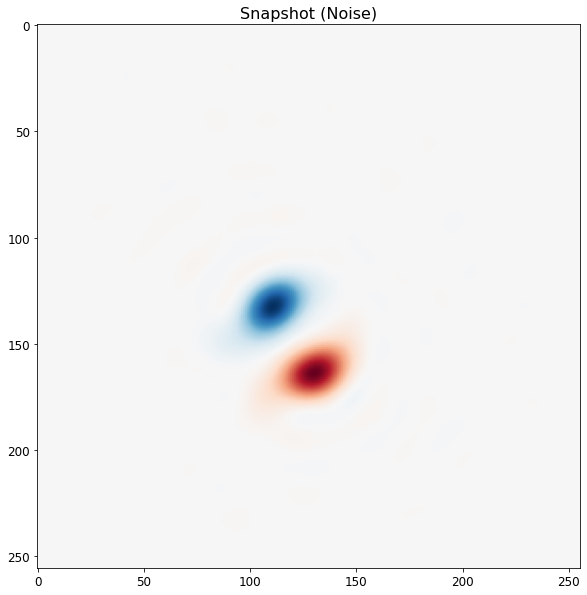

In [141]:

latent_output = encoder(X_train_concat3[5007].reshape(-1, ntimes, num_of_coeff + num_sensors, 1), training=False)
generated_image = decoder(latent_output, training=False)
print(generated_image.shape)
recovered_image = generated_image[:, :, :, :]
recovered_sensor = generated_image[:, :, num_of_coeff:, :]


fig, ax = plt.subplots(figsize=[10,10])
inv_recovered_image = invert_data3(recovered_image[0, :, :, 0])
print(inv_recovered_image.shape)
ax.imshow(inv_recovered_image[0, :].reshape(nx, nx), cmap='RdBu');
ax.set_title('Snapshot (Noise)', fontsize=16);

In [ ]:
decision = discriminator(latent_output)
print(decision)

tf.Tensor([[-15.816337]], shape=(1, 1), dtype=float32)


In [ ]:
autoencoder = tf.keras.models.Sequential([encoder, decoder])

Define Loss function and Optimizer

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
ae_lr=1e-4
d_lr =1e-4
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=ae_lr)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=d_lr)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy( tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return fake_loss + real_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy( tf.ones_like(fake_output), fake_output)
  return fake_loss

In [ ]:
ae_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
gen_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

@tf.function
def train_step(batch):
    # Reconstruction phase
    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
        encoder_output = encoder(batch, training=True)
        decoder_output = decoder(encoder_output)
      
        autoencoder_loss = tf.reduce_mean(tf.square(batch - decoder_output))

    enc_gradients = enc_tape.gradient(autoencoder_loss, encoder.trainable_variables)
    dec_gradients = dec_tape.gradient(autoencoder_loss, decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(enc_gradients, encoder.trainable_variables))
    ae_optimizer.apply_gradients(zip(dec_gradients, decoder.trainable_variables))


    # Regularization phase 
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        generated_z = encoder(batch, training=True)
        fake_output = discriminator(generated_z, training=True)
       
        real_z = np.random.normal(size=(BATCH_SIZE, latent_dim))
        real_output = discriminator(real_z, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
      
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      
    gradients_of_generator = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, encoder.trainable_variables))

    

    ae_mean_loss(autoencoder_loss)
    discriminator_mean_loss(disc_loss)
    gen_mean_loss(gen_loss)

#### Training AAE

In [ ]:
# logs to document losses
version_num = 'E500_125b_AAEsen'

generator_log_dir = SAVE_DIR + 'logs/generator_v6_new' + str(version_num) + '_'+ str(num_of_coeff)
discriminator_log_dir = SAVE_DIR + 'logs/discriminator_v6_new' + str(version_num) + '_'+ str(num_of_coeff)
ae_log_dir = SAVE_DIR + 'logs/ae_v5' + str(version_num) + '_'+ str(num_of_coeff)

gen_summary = tf.summary.create_file_writer(generator_log_dir)
disc_summary = tf.summary.create_file_writer(discriminator_log_dir)
ae_summary = tf.summary.create_file_writer(ae_log_dir)


print('Version no.: ', version_num)
print('POD coeffiecients: ', num_of_coeff + num_sensors)
print('Batch size: ', BATCH_SIZE)
print('Learning Rate: ', ae_lr, '(gen),', d_lr, '(disc)')
print('Instances: ', ntimes)
print('Time steps: ', step)

Version no.:  E500_125b_AAEsen
POD coeffiecients:  317
Batch size:  125
Learning Rate:  0.0001 (gen), 0.0001 (disc)
Instances:  7
Time steps:  5


In [ ]:
def train(dataset, epochs, cont=0, log=True):
    hist = []
    seed = tf.random.normal([num_examples_to_generate, latent_dim])
    for epoch in range(epochs+1):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1 + cont, epochs + cont))   

        for batch in dataset:
            train_step(batch)
        if log:
          with gen_summary.as_default() :
              tf.summary.scalar('loss', gen_mean_loss.result(), step=epoch)
          with disc_summary.as_default():
              tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
          with ae_summary.as_default():
              tf.summary.scalar('loss', ae_mean_loss.result(), step=epoch)
          
          
        hist.append([ae_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy(), gen_mean_loss.result().numpy()])

        ae_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        gen_mean_loss.reset_states()
        print("discriminator loss: ", "{:.7f}".format(hist[-1][1]), end=' - ')
        print("generator loss: ", "{:.7f}".format(hist[-1][2]), end=' - ')
        print("autoencoder loss: ", "{:.7f}".format(hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        pred_time_len = 4
        # Global variables are used below
        if epoch%500 == 0: 
            # Plot generated data
            X_generated = decoder.predict(seed)
            X_generated = X_generated[:, :, :num_of_coeff, :].reshape(-1, num_of_coeff)
            X_generated = invert_data(X_generated)
            print(X_generated.shape)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, nx, nx)
            fig, ax = plt.subplots(5, pred_time_len, figsize=[20, 25], constrained_layout=True)
            for j in range(5):
              for i in range(pred_time_len):
                im = ax.flatten()[i + (pred_time_len*j)].imshow(X_generated[j][i,:,:], cmap='RdBu')
                ax[j,i].set_xticklabels([]), ax[j,i].set_yticklabels([])
              fig.colorbar(im, ax=ax[j,:], location='right', shrink=0.8, pad=0.05)
            plt.show() 
                    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_ae', 'loss_disc', 'loss_gen'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
        if epoch%500 == 0 and epoch >0:          
            # Save model once greater that 10,000 iterations 
            encoder.save(SAVE_DIR + 'ganmodels/model_v'+ str(version_num) + '_enc_'+ str(epoch +cont)+'.h5')
            decoder.save(SAVE_DIR + 'ganmodels/model_v'+ str(version_num) + '_dec_'+ str(epoch+ cont)+'.h5')
            discriminator.save(SAVE_DIR + 'ganmodels/model_v'+ str(version_num) + '_disc_'+ str(epoch+cont)+'.h5')
    return hist

Epoch 6501/21500
discriminator loss:  370.9820557 - generator loss:  12.3717346 - autoencoder loss:  0.0000226 - 56s
(105, 65536)


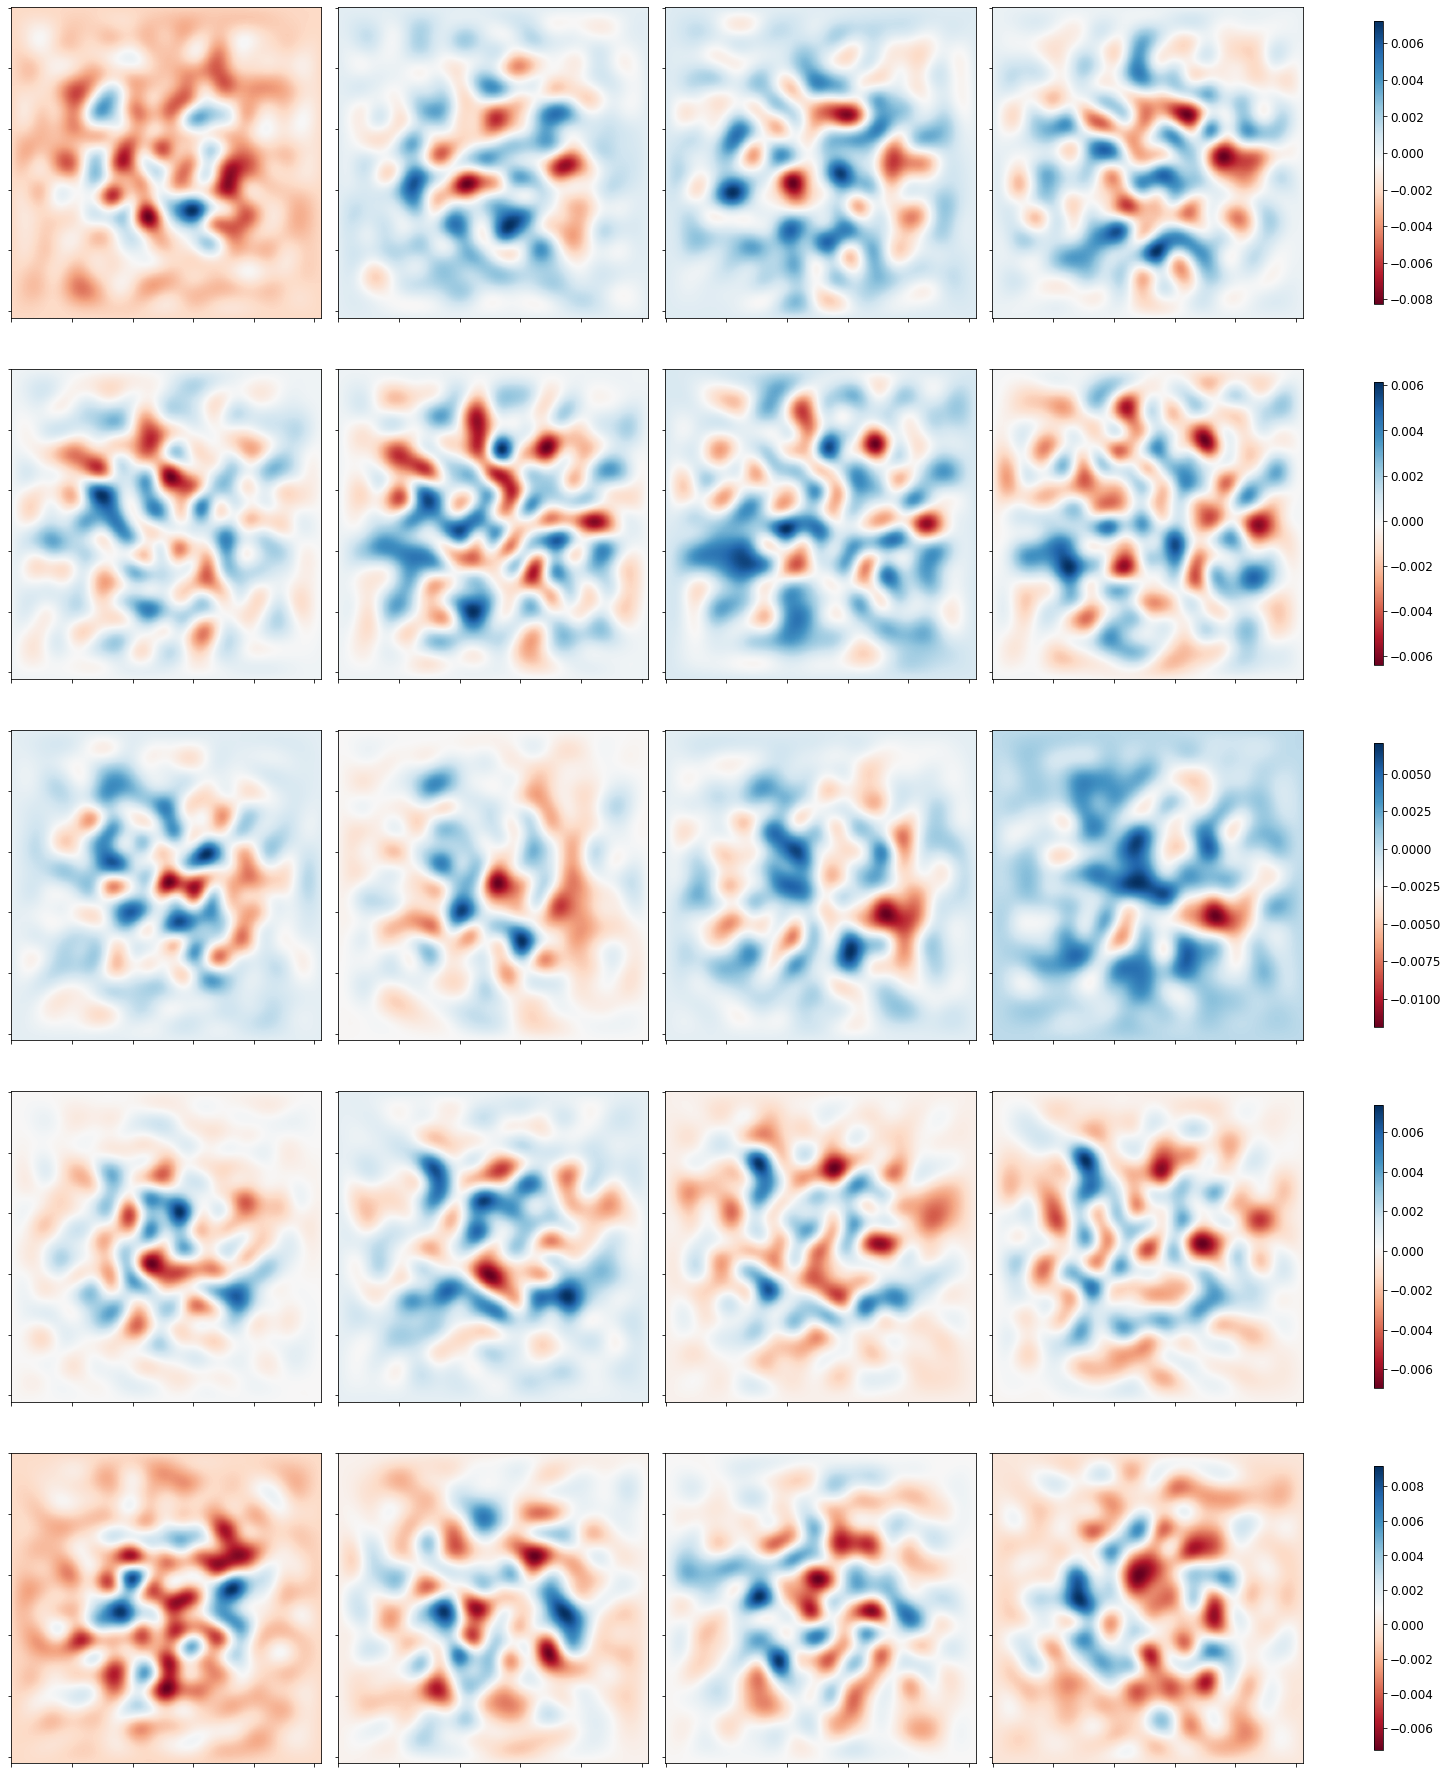

Loss: 


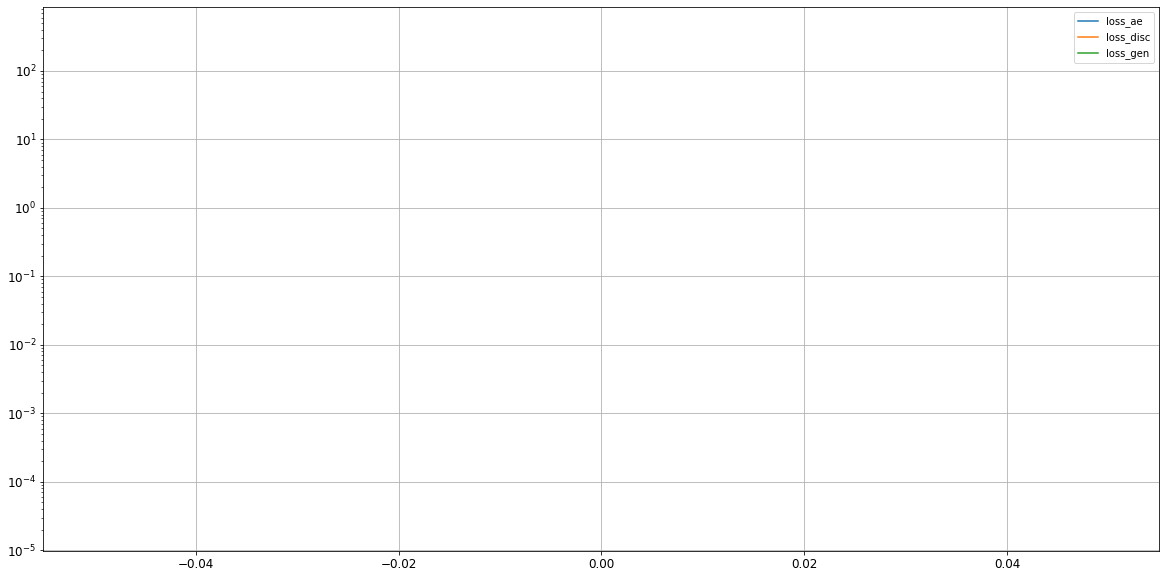

Epoch 6502/21500
discriminator loss:  180.5391998 - generator loss:  5.5640559 - autoencoder loss:  0.0000245 - 37s
Epoch 6503/21500
discriminator loss:  108.5829544 - generator loss:  9.9201784 - autoencoder loss:  0.0000445 - 37s
Epoch 6504/21500
discriminator loss:  68.4610596 - generator loss:  9.0953712 - autoencoder loss:  0.0000435 - 37s
Epoch 6505/21500
discriminator loss:  42.2765617 - generator loss:  8.0369463 - autoencoder loss:  0.0000387 - 37s
Epoch 6506/21500
discriminator loss:  25.1020508 - generator loss:  7.7692089 - autoencoder loss:  0.0000359 - 37s
Epoch 6507/21500
discriminator loss:  14.3388319 - generator loss:  6.0634308 - autoencoder loss:  0.0000325 - 37s
Epoch 6508/21500
discriminator loss:  9.5335932 - generator loss:  5.6867771 - autoencoder loss:  0.0000296 - 37s
Epoch 6509/21500
discriminator loss:  7.0507050 - generator loss:  5.5867639 - autoencoder loss:  0.0000275 - 37s
Epoch 6510/21500
discriminator loss:  5.6250806 - generator loss:  5.2633615 - a

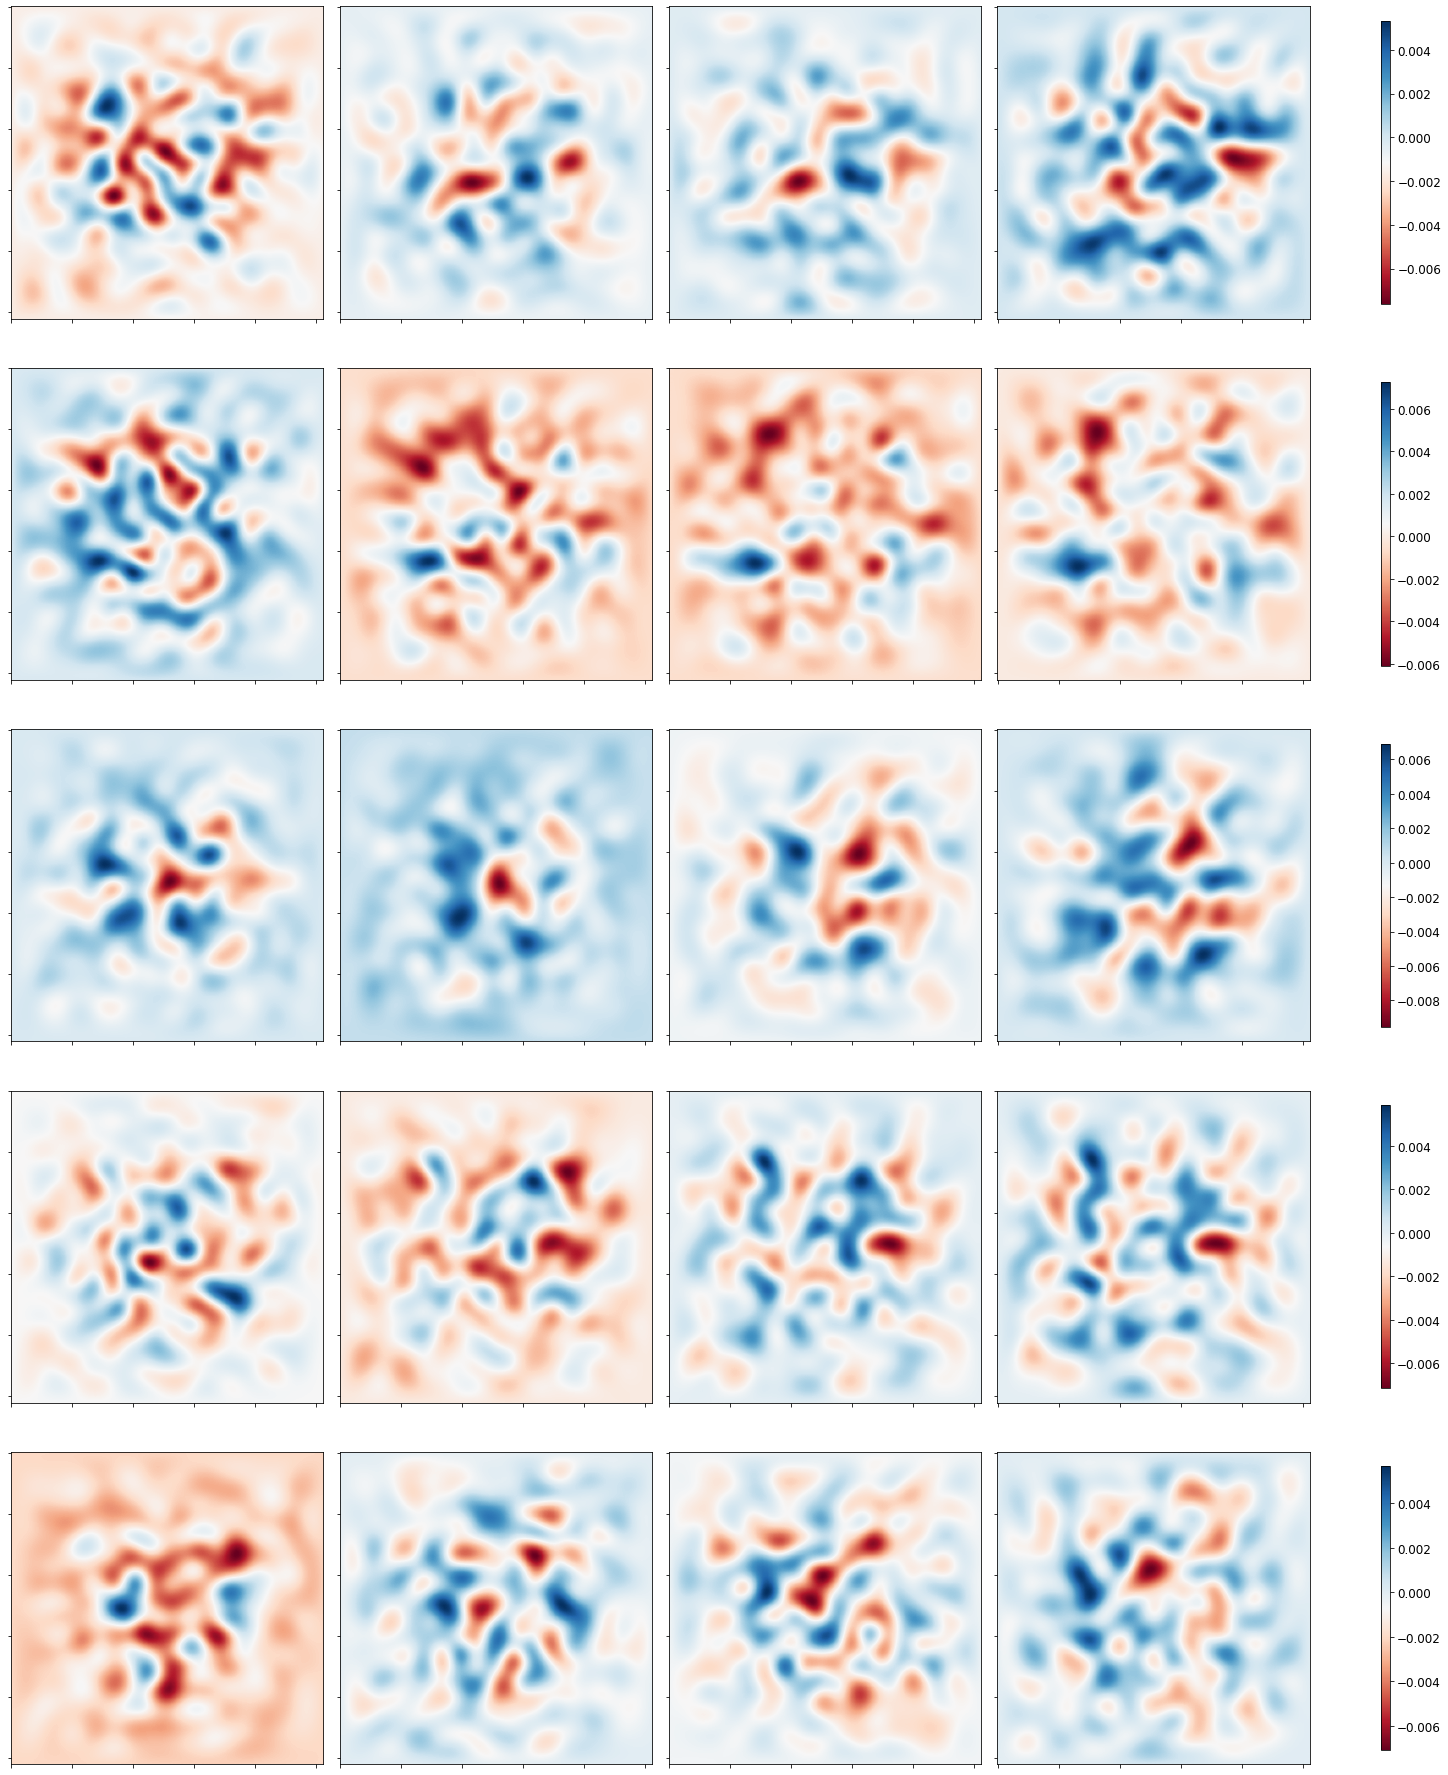

Loss: 


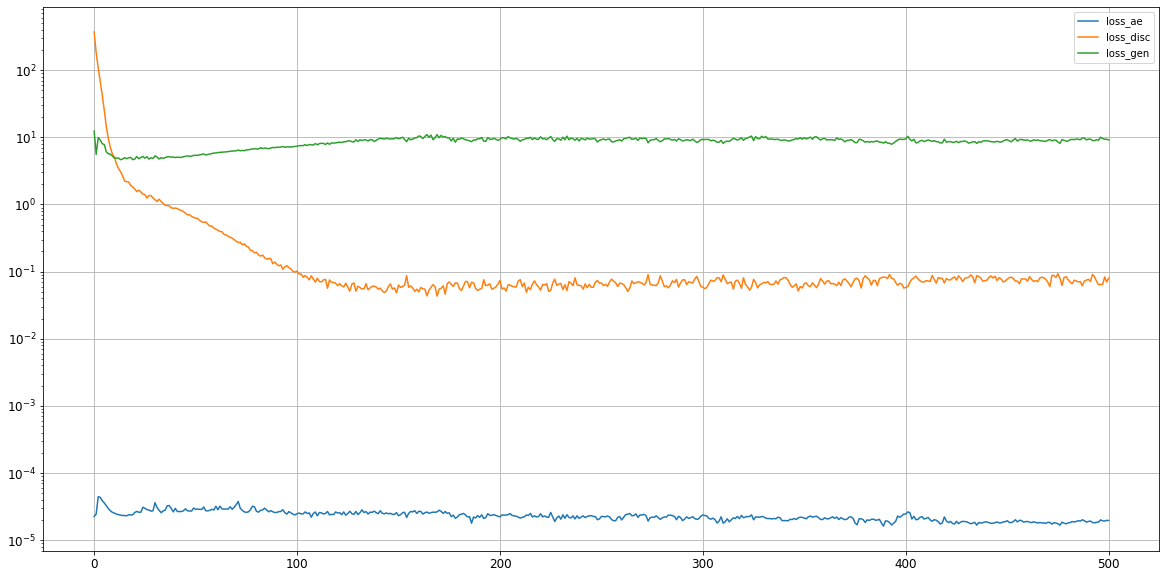

Epoch 7002/21500
discriminator loss:  0.0696229 - generator loss:  9.1598721 - autoencoder loss:  0.0000200 - 37s
Epoch 7003/21500
discriminator loss:  0.0629932 - generator loss:  9.9831657 - autoencoder loss:  0.0000205 - 37s
Epoch 7004/21500
discriminator loss:  0.0662305 - generator loss:  9.6780653 - autoencoder loss:  0.0000206 - 37s
Epoch 7005/21500
discriminator loss:  0.0707031 - generator loss:  9.2862682 - autoencoder loss:  0.0000202 - 37s
Epoch 7006/21500
discriminator loss:  0.0717539 - generator loss:  9.4924765 - autoencoder loss:  0.0000201 - 37s
Epoch 7007/21500
discriminator loss:  0.0739906 - generator loss:  9.3241644 - autoencoder loss:  0.0000200 - 37s
Epoch 7008/21500
discriminator loss:  0.0759976 - generator loss:  9.3625174 - autoencoder loss:  0.0000194 - 37s
Epoch 7009/21500
discriminator loss:  0.0684025 - generator loss:  9.8157578 - autoencoder loss:  0.0000205 - 37s
Epoch 7010/21500
discriminator loss:  0.0763815 - generator loss:  9.4204540 - autoencod

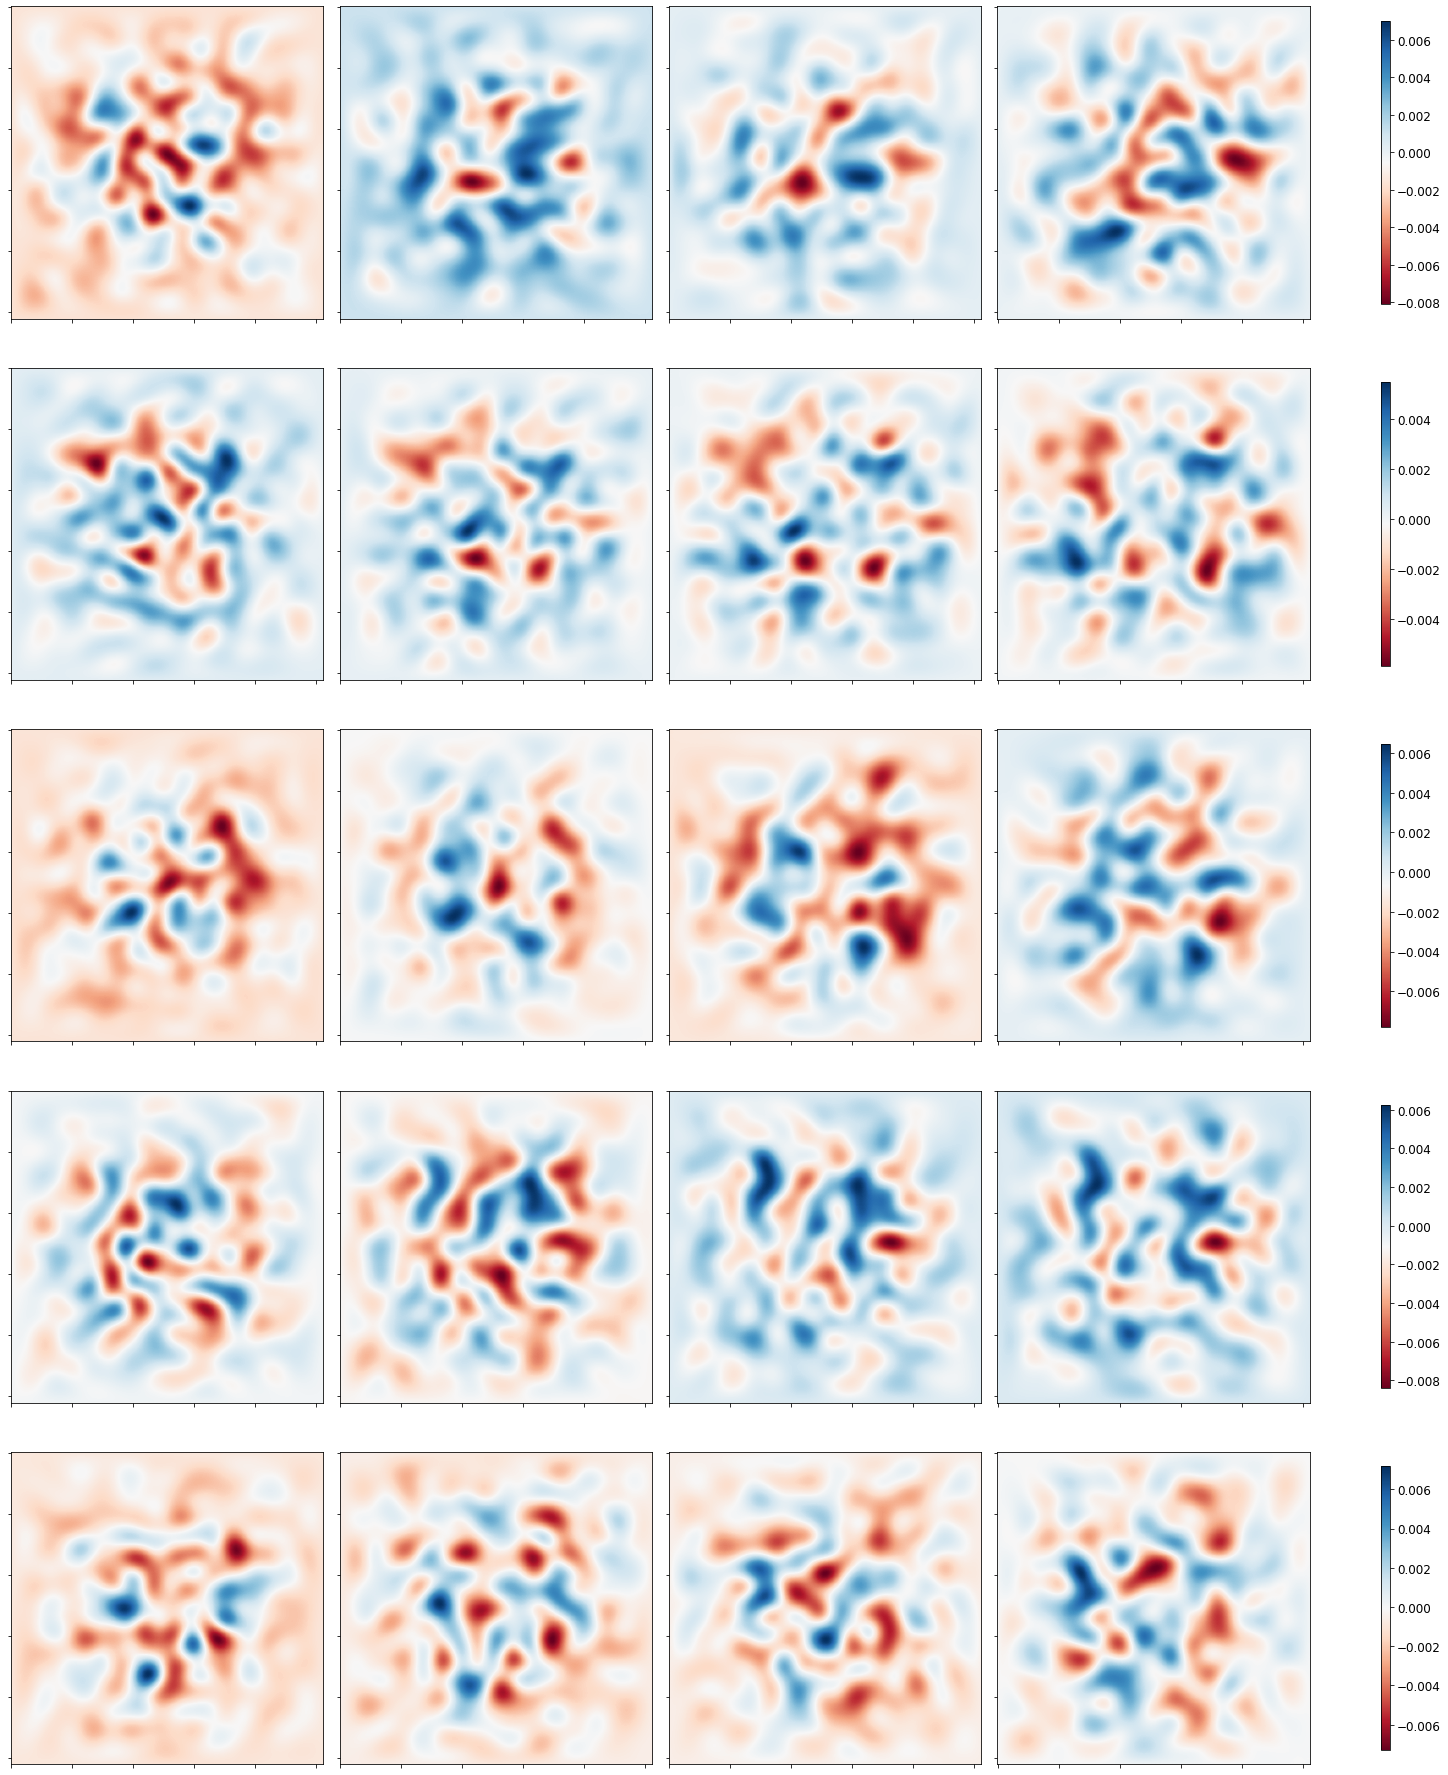

Loss: 


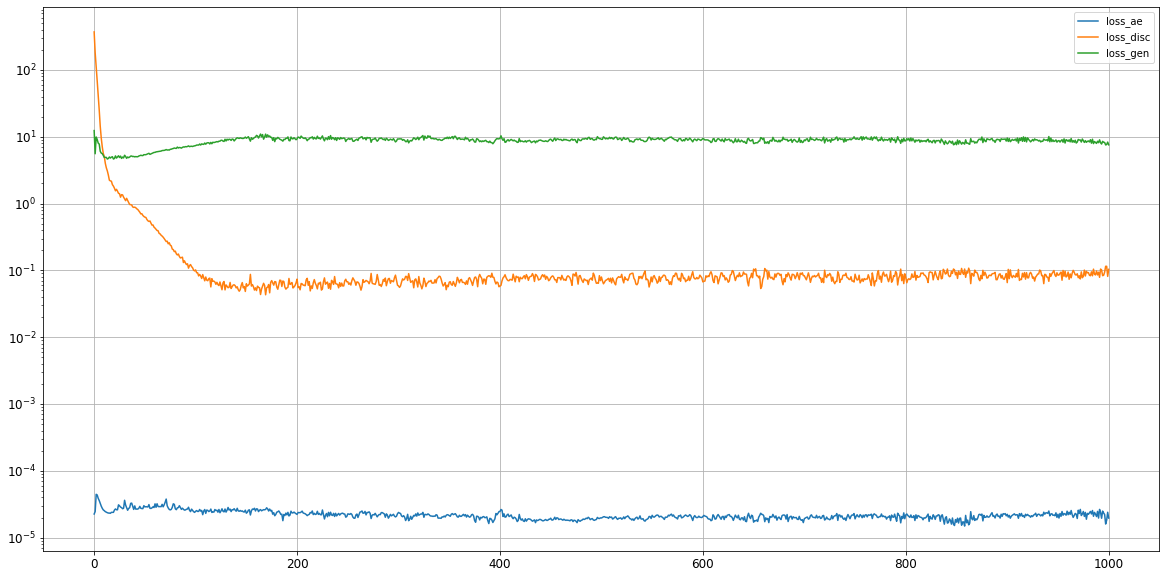

Epoch 7502/21500
discriminator loss:  0.1074275 - generator loss:  7.9253502 - autoencoder loss:  0.0000169 - 37s
Epoch 7503/21500
discriminator loss:  0.1020356 - generator loss:  7.9047475 - autoencoder loss:  0.0000215 - 37s
Epoch 7504/21500
discriminator loss:  0.1101769 - generator loss:  7.5885448 - autoencoder loss:  0.0000192 - 37s
Epoch 7505/21500
discriminator loss:  0.1266252 - generator loss:  7.0540085 - autoencoder loss:  0.0000138 - 37s
Epoch 7506/21500
discriminator loss:  0.1114673 - generator loss:  7.5164218 - autoencoder loss:  0.0000168 - 37s
Epoch 7507/21500
discriminator loss:  0.0673792 - generator loss:  8.6088724 - autoencoder loss:  0.0000262 - 37s
Epoch 7508/21500
discriminator loss:  0.0798578 - generator loss:  8.1083632 - autoencoder loss:  0.0000249 - 37s
Epoch 7509/21500
discriminator loss:  0.1040304 - generator loss:  7.4980397 - autoencoder loss:  0.0000178 - 37s
Epoch 7510/21500
discriminator loss:  0.1064120 - generator loss:  7.6907430 - autoencod

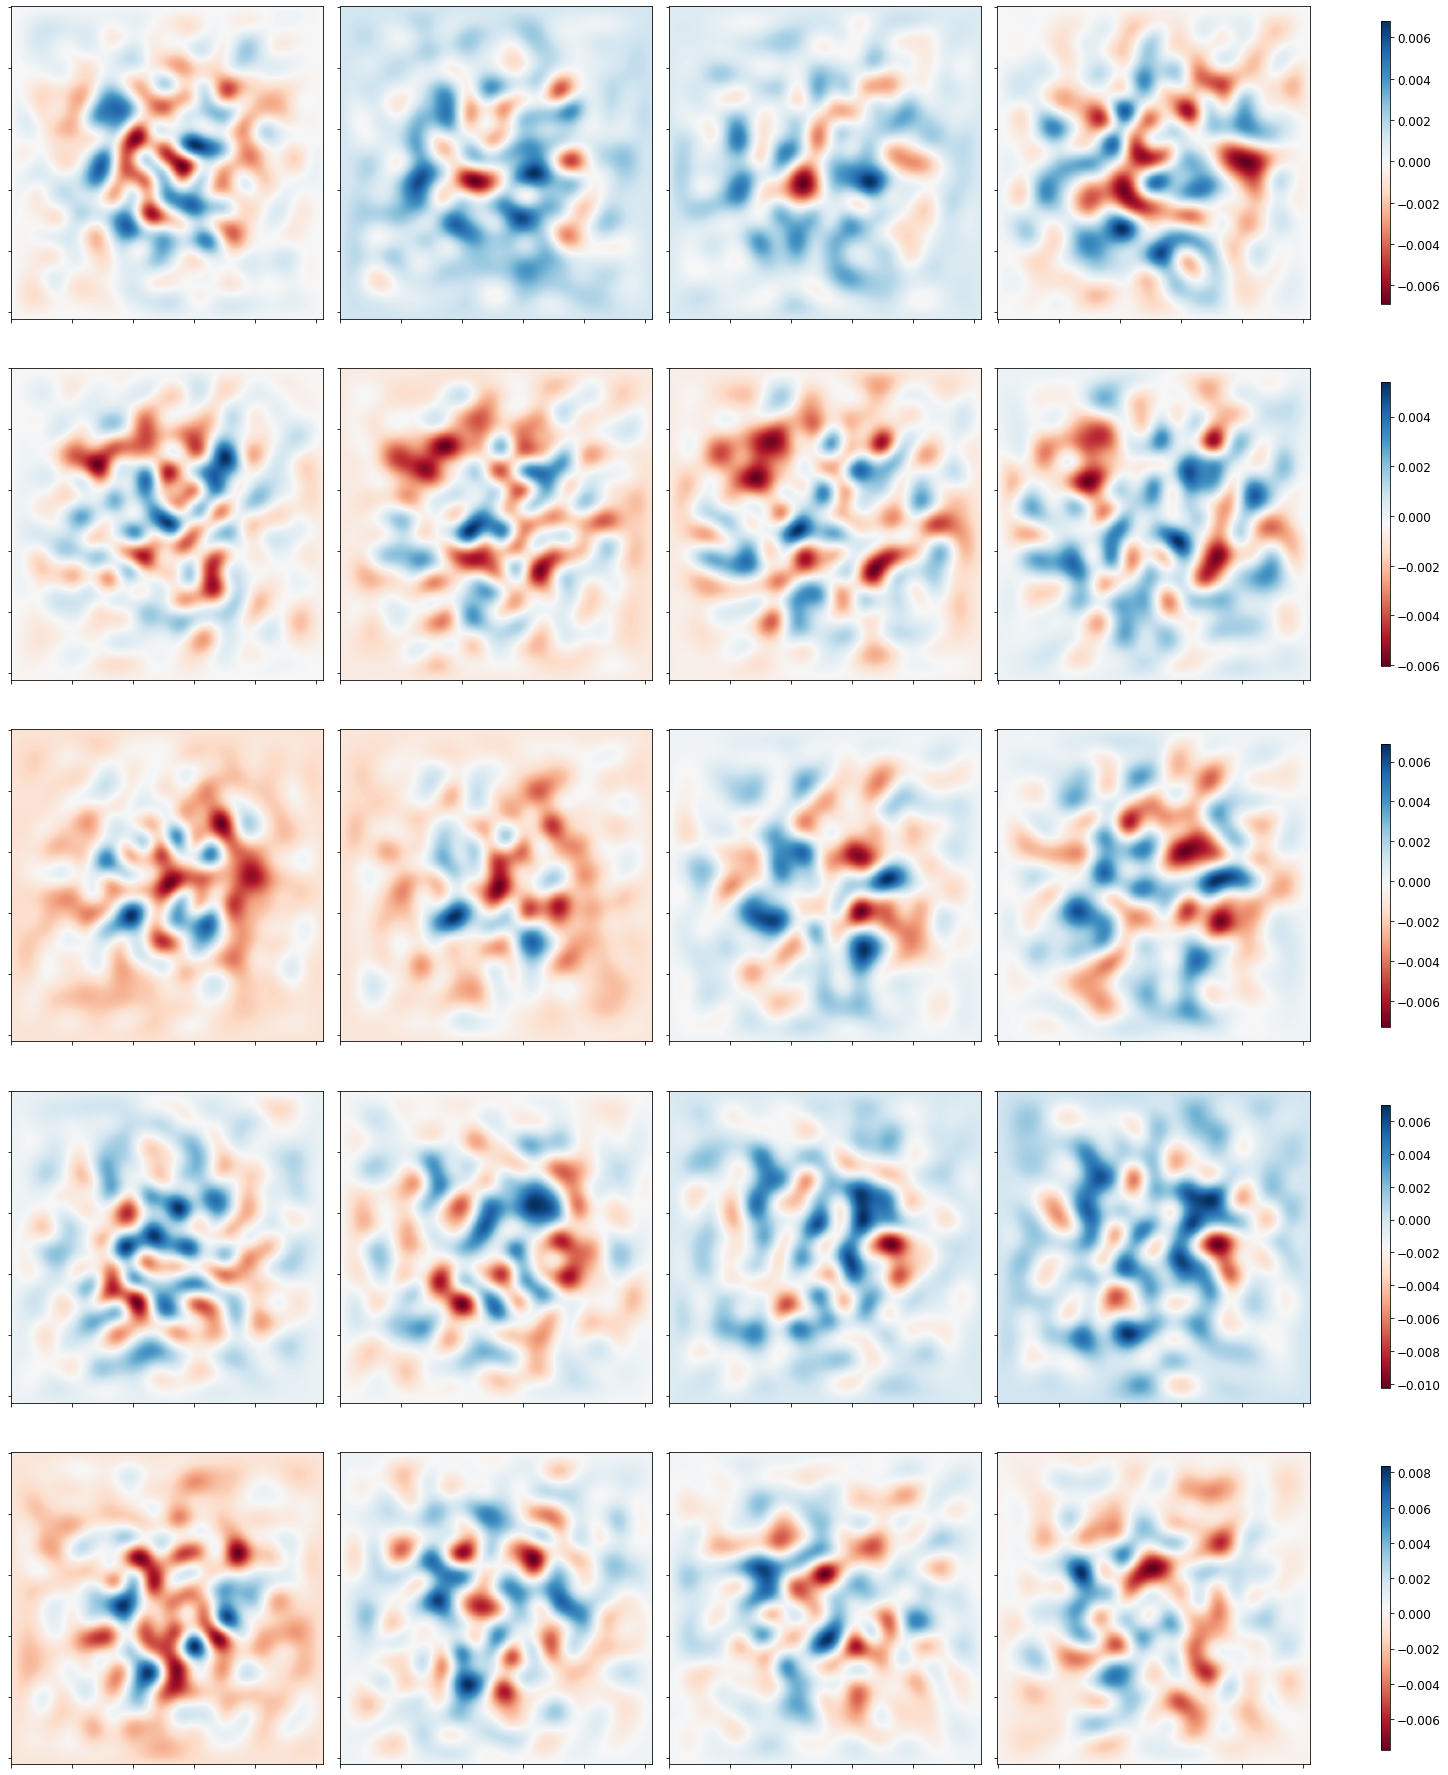

Loss: 


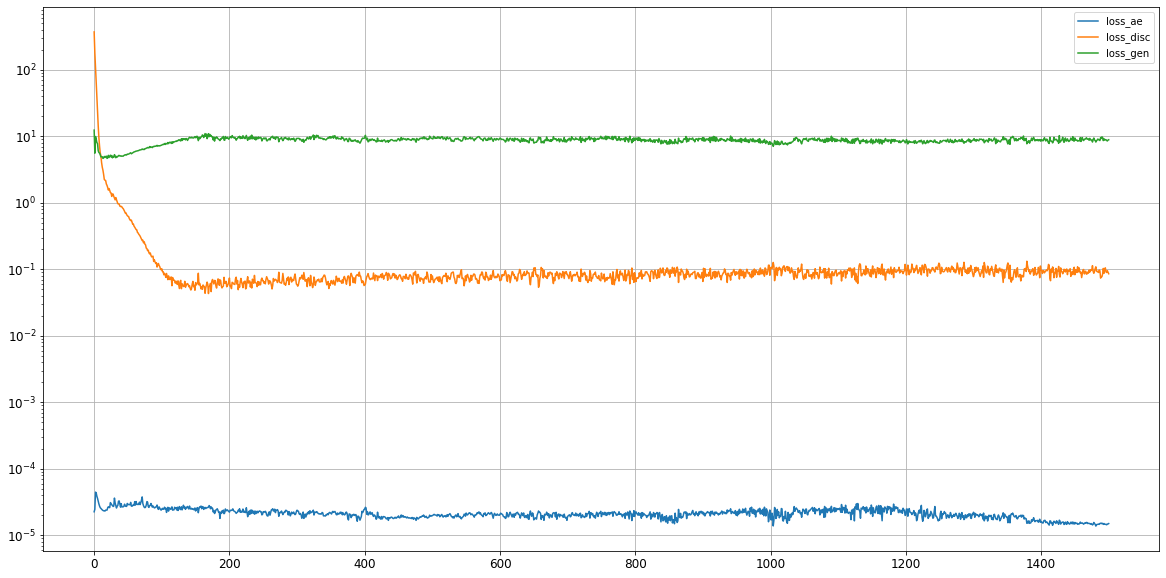

Epoch 8002/21500
discriminator loss:  0.1000327 - generator loss:  9.2358389 - autoencoder loss:  0.0000151 - 37s
Epoch 8003/21500
discriminator loss:  0.0992398 - generator loss:  8.6760464 - autoencoder loss:  0.0000147 - 37s
Epoch 8004/21500
discriminator loss:  0.0874990 - generator loss:  8.8057261 - autoencoder loss:  0.0000146 - 37s
Epoch 8005/21500
discriminator loss:  0.0953858 - generator loss:  8.7873306 - autoencoder loss:  0.0000146 - 37s
Epoch 8006/21500
discriminator loss:  0.0913540 - generator loss:  9.2237749 - autoencoder loss:  0.0000153 - 37s
Epoch 8007/21500
discriminator loss:  0.0919837 - generator loss:  9.1704969 - autoencoder loss:  0.0000149 - 37s
Epoch 8008/21500
discriminator loss:  0.0985408 - generator loss:  8.7776709 - autoencoder loss:  0.0000148 - 37s
Epoch 8009/21500
discriminator loss:  0.1005822 - generator loss:  8.8058691 - autoencoder loss:  0.0000149 - 37s
Epoch 8010/21500
discriminator loss:  0.0819903 - generator loss:  8.8691483 - autoencod

In [ ]:
import time 
hist = train(train_dataset, epochs=15000, cont=6500)

#**Prediction with AAE**

### Predict a point in time

In [15]:
def forward_march(n=0, forward_steps=1, epsilon=1e-5, visualize=False):
  codings_size = num_of_coeff + num_sensors
  real_coding = X_train_concat3[n].reshape(1,-1).copy()
  print(real_coding.shape)
  # original data input
  img_series = real_coding[:, :codings_size*(ntimes-1)].reshape(-1, ntimes-1, codings_size, 1)
  input_coding = np.concatenate((real_coding[:, :codings_size*(ntimes-1)], real_coding[ :, codings_size*(ntimes-2):codings_size*(ntimes-1)]), axis=1)

  input_guess = input_coding.reshape(-1, ntimes, codings_size, 1) # holds the intiial guess of new time step
  

  step_loss = 1.0
  label = 0
  march_loss = []
  for step in range(forward_steps):
    loss = []
    # fig, ax = plt.subplots(figsize=[10,10])
    for _ in range(10) :
      encoded_img = encoder(input_guess, training=False)
      decoded_img = decoder(encoded_img, training=False)
      # new_pred = decoded_img[:, -1, :num_of_coeff, :]
      new_pred = decoded_img[:, -1, :, :]
      
      criterion = tf.math.subtract(input_guess[:, -1, :, :] , new_pred)
      step_loss = tf.reduce_sum(criterion)
      loss.append(step_loss)

      input_guess[:, -1, :, :] = new_pred

    if visualize:
      label +=1 
      plt.plot(loss, label='loss step '+str(label))
      plt.legend()
    march_loss.append(loss)
    new_time_lvl =  input_guess[:, -1, :, :].reshape(-1, 1, codings_size, 1)
    
    # add new time level from prediction to image series
    img_series = np.concatenate((img_series,new_time_lvl), axis=1)

    # re-configure input for next forward prediction.
    # drop the first step and use the final step as intial guess
    input_guess = input_guess[:, 1:, :, :]
    input_guess = np.concatenate((input_guess, [input_guess[:, -1, :, :]]), axis=1)
    if visualize:
      plt.grid()
      plt.show
  return img_series, march_loss



(1, 2044)


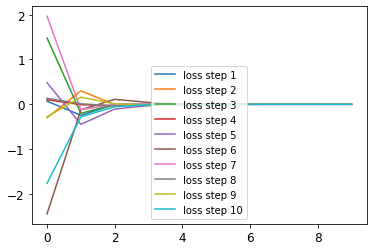

In [16]:
np.random.seed(0)
tf.random.set_seed(0)
n = 4560
codings_size = num_of_coeff
# Predict multiple points using AAE

X_gen_AAE, loss = forward_march(n, 10, 1e-5, visualize=True)

In [21]:
loss[-1]

[<tf.Tensor: shape=(), dtype=float32, numpy=-1.7637122>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.281085>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.054960907>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0055974275>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.003435269>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0025514364>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0009185374>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0002567917>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3797154e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-2.8163195e-06>]

In [32]:
def backward_march(n=0, forward_steps=1, epsilon=1e-5, visualize=False):
 
  real_coding = X_test_concat[n].reshape(1,-1).copy()
  # original data input
  img_series = real_coding[:, :codings_size*(ntimes-1)].reshape(-1, ntimes-1, codings_size, 1)

  # use penultimate time step as initial guess 
  input_coding = np.concatenate((real_coding[:, :codings_size*(ntimes-1)], real_coding[ :, codings_size*(ntimes-2):codings_size*(ntimes-1)]), axis=1)

  input_guess = input_coding.reshape(-1, ntimes, codings_size, 1) # holds the intiial guess of new time step
  
  step_loss = 1.0
  label = 0
  march_loss = []
  for step in range(forward_steps):
    loss = []
    for _ in range(5) :
      encoded_img = encoder(input_guess)
      decoded_img = decoder(encoded_img)
      new_pred = decoded_img[:, -1, :, :]
      criterion = tf.math.subtract(input_guess[:, -1, :, :] , new_pred)
      step_loss = tf.reduce_sum(criterion)
      loss.append(step_loss)

      input_guess[:, -1, :, :] = new_pred

    if visualize:
      label +=1 
      plt.plot(loss, label='loss step '+str(label))
      plt.legend()
    march_loss.append(loss)
    new_time_lvl =  input_guess[:, -1, :, :].reshape(-1, 1, num_of_coeff, 1)
    
    # add new time level from prediction to image series
    img_series = np.concatenate((img_series,new_time_lvl), axis=1)

    # re-configure input for next forward prediction.
    # drop the first step and use the final step as intial guess
    input_guess = input_guess[:, 1:, :, :]
    input_guess = np.concatenate((input_guess, [input_guess[:, -1, :, :]]), axis=1)
    if visualize:
      plt.grid()
      plt.show
  return img_series, march_loss

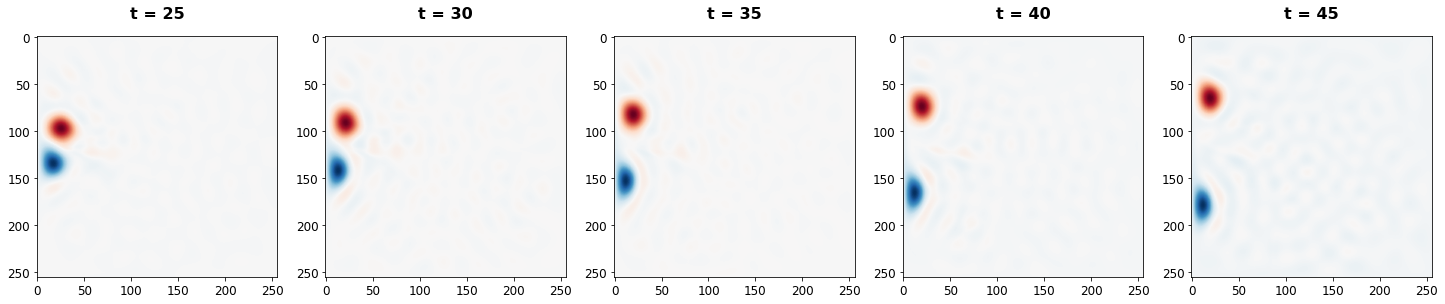

In [22]:
sensor_data = X_gen_AAE[:,:,codings_size:, :]
gen_data_AAE = X_gen_AAE[:,:,:codings_size, :]
pred = invert_data(gen_data_AAE.reshape(-1,codings_size), flag='3').reshape(-1, nx, nx)
times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_vortex(pred, times[-5:], cols=5, rows=1, skips=5, c_bar=False)

(10, 256, 256)


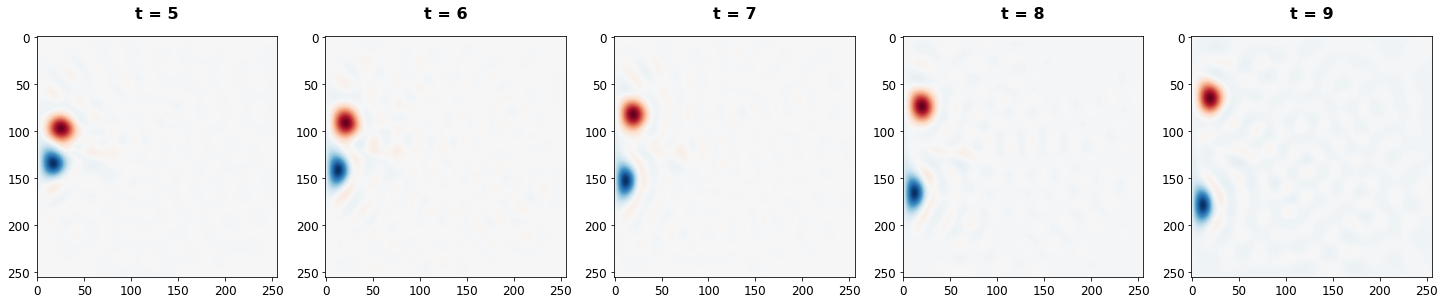

In [23]:
orig_start = int(n*2.5) 
orig_end = int((n*2.5)+ 50)
X_original = X_train1d_pca_scaled3[orig_start:orig_end:5]
X_real_all = invert_data(X_original, flag='3')
X_real_all = X_real_all.reshape(-1, nx,nx)
print(X_real_all.shape)
plot_vortex(X_real_all, times[-5:], 5, 1, c_bar=False)

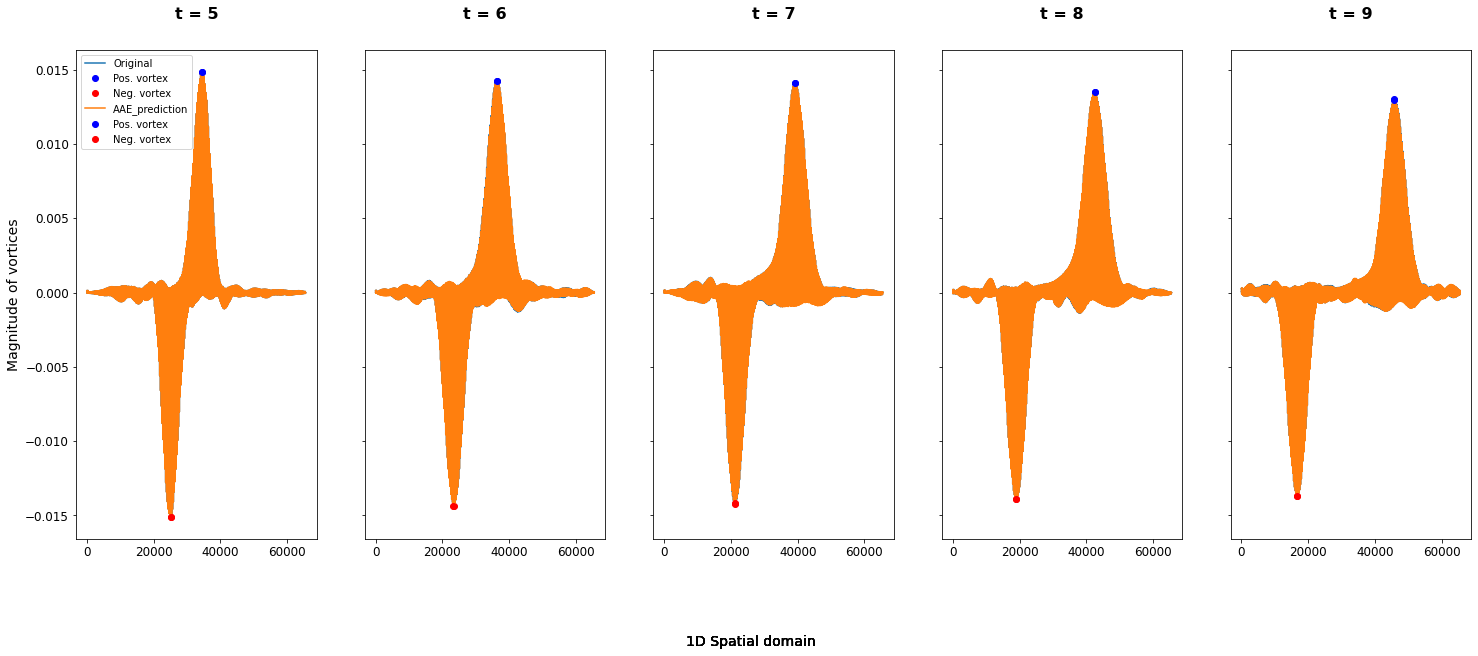

In [149]:
aae_pred_dict = {'Original':X_real_all, 'AAE_prediction':pred}
plot_linevortex(aae_pred_dict, times[-5:], cols=5, rows=1)